# Feb ??th, 2022 ()

**Motivation**: <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Prepare

In [2]:
mice = Mice(128)
mice.setup_func_data('rest')

fig_dir = pjoin(tmp_dir, 'fig_corr-timeseries')
os.makedirs(fig_dir, exist_ok=True)

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.65), 'bold-lite': rocket(0.6)}

## Contiguous segments

In [3]:
segments = collections.defaultdict(list)
for key in mice.bold:
    *_, run = mice.looper[key]
    if run == -1:
        continue
    bb = Base(mice, key=key, mode='bold-lite')
    nan_frames = np.isnan(bb.data).sum(0) == len(bb.data)
    clean = np.where(~nan_frames)[0]
    for k, g in itertools.groupby(enumerate(clean), lambda t: t[0] - t[1]):
        s = map(operator.itemgetter(1), g)
        segments[key].append(list(s))
segments = dict(segments)
len(segments)

114

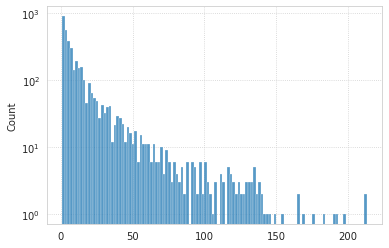

In [4]:
lens = []
for seg in segments.values():
    lens += [len(e) for e in seg]

sns.histplot(lens)
plt.yscale('log');

In [7]:
key2id = collections.defaultdict(list)
data = collections.defaultdict(list)
identifier = 0
for key, seglist in segments.items():
    sub, ses, run = mice.looper[key]
    bc = Base(mice, key=key, mode='ca2')
    bb = Base(mice, key=key, mode='bold-lite')
    for seg in seglist:
        if len(seg) < 10:
            continue
        x = bb.data[:, seg]
        a, b = min(seg), max(seg)
        seg_up = range(a * 10, b * 10)
        y = bc.data[:, seg_up]
        nonan = np.logical_and(
            np.isnan(x).sum(1) == 0,
            np.isnan(y).sum(1) == 0,
        )
        x_up = sp_sig.resample(x, len(seg_up), axis=1)

        d = sp_dist.cdist(
            XA=x_up[nonan],
            XB=y[nonan],
            metric='correlation',
        )
        best_i = np.nanargmin(np.diag(d))
        roi = np.where(nonan)[0][best_i]

        data[mice.get_key(sub)].append({
            'd': d,
            'timepoint': seg_up,
            'x': sp_stats.zscore(x_up[roi]),
            'y': sp_stats.zscore(y[roi]),
            'rho': 1 - d[best_i, best_i],
            'roi': roi,
            'key': key,
            'identifier': identifier,
        })
        key2id[key].append(identifier)
        identifier += 1
key2id = dict(key2id)
data = dict(data)
for k, dlist in data.items():
    data[k] = sorted(dlist, key=lambda e: e['rho'], reverse=True)

In [8]:
{k: len(v) for k, v in data.items()}

{
    'sub-SLC01': 165,
    'sub-SLC02': 120,
    'sub-SLC03': 169,
    'sub-SLC04': 169,
    'sub-SLC05': 138,
    'sub-SLC06': 154,
    'sub-SLC07': 145,
    'sub-SLC08': 144,
    'sub-SLC09': 152,
    'sub-SLC10': 144
}

In [9]:
selected_ids = {
    'sub-SLC01': [55, 19, 65, 7, 44, 42, 146],
    'sub-SLC02': [236, 252, 269, 177, 213, 200, 211],
    'sub-SLC03': [333, 337, 388, 399, 368, 338, 386],
    'sub-SLC04': [457, 483, 586, 614, 516, 510, 541],
    'sub-SLC05': [660, 704, 754, 626, 725, 665, 661],
    'sub-SLC06': [817, 874, 827, 899, 816, 814, 900],
    'sub-SLC07': [988, 953, 986, 992, 987, 963, 1013],
    'sub-SLC08': [1098, 1140, 1080, 1093, 1090, 1178, 1086],
    'sub-SLC09': [1327, 1294, 1324, 1254, 1302, 1250, 1297],
    'sub-SLC10': [1386, 1468, 1444, 1380, 1447, 1395, 1476],
}

In [10]:
ncols, nrows = 7, 10
fig, axes = create_figure(
    nrows=nrows,
    ncols=ncols,
    figsize=(4.1 * ncols, 2.55 * nrows),
)
for i, (k, dlist) in enumerate(data.items()):
    selected_data = [
        d for d in dlist if
        d['identifier'] in selected_ids[k]
    ]
    for j, d in enumerate(selected_data):
        ax = axes[i, j]
        ax.plot(d['timepoint'], d['y'], lw=1.5, color=pal['ca2'], label='ca')
        ax.plot(d['timepoint'], d['x'], lw=1.5, color=pal['bold-lite'], label='bold')
        ax.set_title(f"id = {d['identifier']}  /  roi # {d['roi']}  .  .  .  rho = {d['rho']:.2f}")

        if len(d['timepoint']) >= 1000:
            delta = 300
        elif 200 <= len(d['timepoint']) < 1000:
            delta = 100
        else:
            delta = 50
        xticks = [t for t in d['timepoint'] if t % delta == 0]
        xticklabels = [int(t / 10) for t in xticks]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
        if (1 + j) % ncols == 0:
            ax.legend()
            axtw = ax.twinx()
            axtw.set_ylabel(k, fontsize=15, rotation=-90, labelpad=30)
            axtw.yaxis.set_label_position("right")
            axtw.set_yticks([])
add_grid(axes)
sup = fig.suptitle("Top 7 segments selected per subject", fontsize=30, y=1.02)
fig.savefig(pjoin(fig_dir, f"All-top7-{now()}.pdf"), bbox_inches='tight')
plt.close()

In [19]:
identifier = 510
d = [
    d for d in data['sub-SLC04'] if
    d['identifier'] == identifier
].pop()

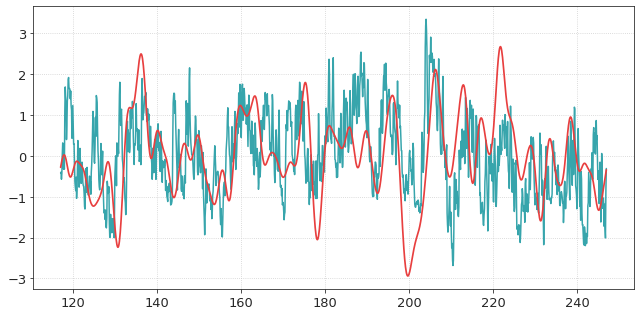

In [46]:
fig, ax = create_figure(figsize=(9, 4.5))

ax.plot(d['timepoint'], d['y'], lw=1.5, color=pal['ca2'], label='ca')
ax.plot(d['timepoint'], d['x'], lw=1.7, color=pal['bold-lite'], label='bold')

delta = 200
xticks = [t for t in d['timepoint'] if t % delta == 0]
xticklabels = [int(t / 10) for t in xticks]

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

# ax.set_xlabel('Time [seconds]', fontsize=15)
# ax.set_ylabel('Normalized activation', fontsize=15)

ax.tick_params(axis='both', labelsize=13)

ax.grid()

name = 'Corr-timeseries'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight', dpi=dpi)

plt.show()

In [44]:
fig_dir

'/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_corr-timeseries'